In [2]:
# Top cells per group

In [3]:
%load_ext autoreload
%autoreload 2
import cascade as cas
import flow
import pool
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import lines
from copy import deepcopy
import scipy as sp
import bottleneck as bt

# except: 
import tensortools as tt
from flow.misc import wordhash
from cascade import utils
from cascade import paths
from cascade import tca
from functools import reduce

In [4]:
# useful lookup tables
color_dict = {'plus': [0.46, 0.85, 0.47, 1],
     'minus': [0.84, 0.12, 0.13, 1],
     'neutral': [0.28, 0.68, 0.93, 1],
     'learning': [34/255, 110/255, 54/255, 1],
     'reversal': [173/255, 38/255, 26/255, 1],
     'gray': [163/255, 163/255, 163/255, 1]}

lookup = {'OA27': {'plus': 270, 'minus': 135, 'neutral': 0},
     'VF226': {'plus': 0, 'minus': 270, 'neutral': 135},
     'OA67': {'plus': 0, 'minus': 270, 'neutral': 135},
     'OA32': {'plus': 135, 'minus': 0, 'neutral': 270},
     'OA34': {'plus': 270, 'minus': 135, 'neutral': 0},
     'OA36': {'plus': 0, 'minus': 270, 'neutral': 135},
     'OA26': {'plus': 270, 'minus': 135, 'neutral': 0}}

lookup_ori = {'OA27': {270: 'plus', 135: 'minus', 0: 'neutral'},
     'VF226': {0: 'plus', 270: 'minus', 135: 'neutral'},
     'OA67': {0: 'plus', 270: 'minus', 135: 'neutral'},
     'OA32': {135: 'plus', 0: 'minus', 270: 'neutral'},
     'OA34': {270: 'plus', 135: 'minus', 0: 'neutral'},
     'OA36': {0: 'plus', 270: 'minus', 135: 'neutral'},
     'OA26': {270: 'plus', 135: 'minus', 0: 'neutral'}}

In [5]:
def _first100_bool(meta):
    """
    Helper function to get a boolean vector of the first 100 trials for each day.
    If a day is shorter than 100 trials use the whole day. 
    """
    
    days = meta.reset_index()['date'].unique()

    first100 = np.zeros((len(meta)))
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        daylength = np.sum(dboo)
        if daylength > 100:
            first100[np.where(dboo)[0][:100]] = 1
        else:
            first100[dboo] = 1
    firstboo = first100 > 0
    
    return firstboo

In [6]:
def _last100_bool(meta):
    """
    Helper function to get a boolean vector of the last 100 trials for each day.
    If a day is shorter than 100 trials use the whole day. 
    """
    
    days = meta.reset_index()['date'].unique()

    first100 = np.zeros((len(meta)))
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        daylength = np.sum(dboo)
        if daylength > 100:
            first100[np.where(dboo)[0][-100:]] = 1
        else:
            first100[dboo] = 1
    firstboo = first100 > 0
    
    return firstboo

In [7]:
def _firstlast100_bool(meta):
    """
    Helper function to get a boolean vector of the first and last 100 trials for each day.
    If a day is shorter than 200 trials use the whole day. 
    """
    
    days = meta.reset_index()['date'].unique()

    first100 = np.zeros((len(meta)))
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        daylength = np.sum(dboo)
        if daylength > 100:
            first100[np.where(dboo)[0][-50:]] = 1
            first100[np.where(dboo)[0][:50]] = 1
        else:
            first100[dboo] = 1
    firstboo = first100 > 0
    
    return firstboo

In [8]:
def _mosttrials_bool(meta):
    """
    Helper function to get a boolean vector of the first n trials for each day.
    n = the number of trials on the shortest day.
    """
    
    day_lengths = []
    days = meta.reset_index()['date'].unique()
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        day_lengths.append(np.sum(dboo))
    trialn = np.min(day_lengths)
    
    first100 = np.zeros((len(meta)))
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        first100[np.where(dboo)[0][:trialn]] = 1
    firstboo = first100 > 0
    
    mouse = meta.reset_index()['mouse'].unique()[0]
    print('{}: {} trials are being used to maximize possible trials each day'.format(mouse, trialn))
    
    return firstboo

In [9]:
def _mostlatetrials_bool(meta):
    """
    Helper function to get a boolean vector of the first n trials for each day.
    n = the number of trials on the shortest day.
    """
    
    day_lengths = []
    days = meta.reset_index()['date'].unique()
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        day_lengths.append(np.sum(dboo))
    trialn = np.min(day_lengths)
    
    first100 = np.zeros((len(meta)))
    for di in days:
        dboo  = meta.reset_index()['date'].isin([di]).values
        first100[np.where(dboo)[0][-trialn:]] = 1
    firstboo = first100 > 0
    
    mouse = meta.reset_index()['mouse'].unique()[0]
    print('{}: {} trials are being used to maximize possible trials each day'.format(mouse, trialn))
    
    return firstboo

In [10]:
def _get_fitting_template_defaults(mouse, sigma=3, sec=15.5, normalize=True):
    """
    Helper function for convolving Gaussian kernel with onset, sustained 
    stimulus, stimulus offset, and ensure delivery period. These can then be
    used for simple linear regression or GLM. 
    """

    # preallocate Gaussian kernel convolution 
    gker = []
    
    # dumb params
    blur = sec
    lag = sec/2
    elag = sec/1.5
    # pick ranges of relevant time periods for convolution
    onset_r = np.arange(np.floor(sec + lag), np.round(sec + sec/3 + blur), 1)
    if mouse in ['OA32', 'OA34', 'OA36']:
        sus_r = np.arange(np.floor(sec + lag), np.round(sec*3 + blur), 1)
        off_r = np.arange(np.floor(sec*3 + sec/4 + lag), np.round(sec*3 + sec/3 + blur), 1)
        ensure_r = np.arange(np.floor(sec*3 + sec/3 + elag), np.round(sec*5 + blur), 1)
    else:
        sus_r = np.arange(np.floor(sec + lag), np.round(sec*4 + blur), 1)
        off_r = np.arange(np.floor(sec*4 + sec/4 + lag), np.round(sec*4 + sec/3 + blur), 1)
        ensure_r = np.arange(np.floor(sec*4 + sec/3 + elag), np.round(sec*6 + blur), 1)
    ranges = [onset_r, sus_r, off_r, ensure_r]

    # convolve
    for i in ranges:
        i = [int(s) for s in i]
        starter = np.zeros((108))
        starter[i] = 1
        gker.append(sp.ndimage.gaussian_filter1d(starter, sigma, mode='constant', cval=0))

    # normalize filters
    if normalize:
        gker = [(s - np.min(s))/np.max(s) for s in gker]

    templates = np.vstack(gker).T

    return templates

In [11]:
def _new_day_vec(meta):
    """
    Helper function to get a boolean vector of the first 100 trials for each day.
    Treats initial learning and reversal as a new "day."
    If a day is shorter than 100 trials use the whole day. 
    """
    
    day_vec = np.array(meta.reset_index()['date'].values, dtype='float')
    days = np.unique(day_vec)
    ls = meta['learning_state'].values
    for di in days:
        dboo  = np.isin(day_vec, di)
        states_vec = ls[dboo]
        u_states = np.unique(states_vec)
        if len(u_states) > 1:
            second_state = dboo & (ls == u_states[1])
            day_vec[second_state] += 0.5
    return day_vec

In [12]:
def _new_stage_vec(meta):
    """
    Helper function to get a boolean vector of the first 100 trials for each day.
    Treats initial learning and reversal as a new "day."
    If a day is shorter than 100 trials use the whole day. 
    """
    
    day_vec = np.array(meta.reset_index()['date'].values, dtype='float')
    days = np.unique(day_vec)
    ls = meta['learning_state'].values
    for di in days:
        dboo  = np.isin(day_vec, di)
        states_vec = ls[dboo]
        u_states = np.unique(states_vec)
        if len(u_states) > 1:
            second_state = dboo & (ls == u_states[1])
            day_vec[second_state] += 0.5
    return day_vec

In [13]:
def pref_cue_sorter(plus_map, neutral_map, minus_map):
    
    # prevent any unforseen broadcasting
#     dev_df = deepcopy(dev_df)
    
    # make a single map of mean stimulus values
    stim_time = np.arange(16, 16*4)
    plus_stim = np.nanmean(plus_map[:, stim_time], axis=1)[:, None]
    neutral_stim = np.nanmean(neutral_map[:, stim_time], axis=1)[:, None]
    minus_stim = np.nanmean(minus_map[:, stim_time], axis=1)[:, None]
    df_array = np.concatenate([plus_stim, neutral_stim, minus_stim], axis=1)
    
    # sort neuron factors according to which component had highest weight
    max_fac = np.argmax(df_array, axis=1)
    sort_fac = np.argsort(max_fac)
    sort_max_fac = max_fac[sort_fac]
    first_sort = df_array[sort_fac, :]

    # descending sort within each group of sorted neurons
    second_sort = []
    for i in np.unique(max_fac):
        second_inds = (np.where(sort_max_fac == i)[0])
#         second_sub_sort = np.argsort(first_sort[sort_max_fac == i, 0])
        second_sub_sort = np.argsort(first_sort[sort_max_fac == i, i])
        second_sort.extend(second_inds[second_sub_sort][::-1])

    # apply the second sort
    full_sort = sort_fac[second_sort]
    
    # move all negative responses to the end (still sorted)
    max_sorted_val = np.nanmax(df_array[full_sort, :], axis=1)
    inhib_bool = max_sorted_val < 0
    vals_to_end = full_sort[inhib_bool]
    new_sort = full_sort[~inhib_bool]
    full_sort_neg = np.concatenate([new_sort, vals_to_end])
#     sort_df = dev_df.iloc[full_sort, :]
    
    return full_sort, full_sort_neg



In [14]:
def pref_cue_sorter_flip(plus_map, neutral_map, minus_map, post_plus_map, post_neutral_map, post_minus_map):
    
    # make a single map of mean stimulus values
    stim_time = np.arange(16, 16*4)
    plus_stim = np.nanmean(plus_map[:, stim_time], axis=1)[:, None]
    neutral_stim = np.nanmean(neutral_map[:, stim_time], axis=1)[:, None]
    minus_stim = np.nanmean(minus_map[:, stim_time], axis=1)[:, None]
    df_array = np.concatenate([plus_stim, neutral_stim, minus_stim], axis=1)
    #
    post_plus_stim = np.nanmean((post_plus_map-plus_map)[:, stim_time], axis=1)[:, None]
    post_neutral_stim = np.nanmean((post_neutral_map-neutral_map)[:, stim_time], axis=1)[:, None]
    post_minus_stim = np.nanmean((post_minus_map-minus_map)[:, stim_time], axis=1)[:, None]
    diff_array = np.concatenate([post_plus_stim, post_neutral_stim, post_minus_stim], axis=1)
    
    # sort neuron factors according to which component had highest weight
    max_fac = np.argmax(df_array, axis=1)
    sort_fac = np.argsort(max_fac)
    sort_max_fac = max_fac[sort_fac]
#     first_sort = df_array[sort_fac, :]
    first_sort = diff_array[sort_fac, :]

    # descending sort within each group of sorted neurons
    second_sort = []
    for i in np.unique(max_fac):
        second_inds = (np.where(sort_max_fac == i)[0])
#         second_sub_sort = np.argsort(first_sort[sort_max_fac == i, 0])
        second_sub_sort = np.argsort(first_sort[sort_max_fac == i, i])
        second_sort.extend(second_inds[second_sub_sort])

    # apply the second sort
    full_sort = sort_fac[second_sort]
    
    # move all negative responses to the end (still sorted)
    max_sorted_val = np.nanmax(df_array[full_sort, :], axis=1)
    inhib_bool = max_sorted_val < 0
    vals_to_end = full_sort[inhib_bool]
    new_sort = full_sort[~inhib_bool]
    full_sort_neg = np.concatenate([new_sort, vals_to_end])
#     sort_df = dev_df.iloc[full_sort, :]
    
    return full_sort, full_sort_neg




In [222]:
mice = ['OA27', 'VF226', 'OA67','OA32', 'OA34', 'OA36', 'OA26']
words = ['christina']*len(mice) #viewers
pars = {
    'tags': None,

    # TCA params
    'rank': 20,
    'method': ('ncp_hals',),
    'replicates': 3,
    'fit_options': None,
    'skip_modes': [],
    'negative_modes' :  [],


    # grouping params
    'group_by': 'all3',
    'up_or_down': 'up',
    'use_dprime': False,
    'dprime_threshold': 2,

    # tensor params
    'trace_type': 'zscore_day',
    'cs': '',
    'downsample': True,
    'start_time': -1,
    'end_time': 6,
    'clean_artifacts': None,
    'thresh': 20,
    'warp': False,
    'smooth': True,
    'smooth_win': 6,
    'verbose': True,

    # filtering params
    'exclude_tags': ('disengaged', 'orientation_mapping', 'contrast', 'retinotopy', 'sated'),
    'exclude_conds': ('blank', 'blank_reward', 'pavlovian'),
    'driven': False,
    'drive_css': ('0', '135', '270'),
    'drive_threshold': 1.31, # should change this to 1.31
    'nan_trial_threshold': 0.95,
    'score_threshold': 0.8,

    # other params
    'update_meta': False,
    'three_pt_tf': False,
    'remove_stim_corr': False}

In [15]:
mice = ['OA27', 'VF226', 'OA67','OA32', 'OA34', 'OA36', 'OA26']
words = ['bookmarks']
words.extend(['horrible']*6)

# load in a full size tensor
no_model_list = []
tensor_list = []
id_list = []
bhv_list = []
meta_list = []
for mouse, word in zip(mice, words):
    out = cas.load.load_all_groupday(mouse, word=word, with_model=False, group_by='all3', nan_thresh=0.95)  # return   model, ids, tensor, meta, bhv
    no_model_list.append(out[0])
    tensor_list.append(out[2])
    id_list.append(out[1])
    bhv_list.append(out[4])
    meta_list.append(out[3])

Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [12]:
model_list

[[], [], [], [], [], [], []]

In [302]:
# load TCA models and data

rank = 10
words = ['christina']*len(mice)
nan_thresh = 0.95
group_by = 'l_vs_r1_tight'
# group_by = 'high_dprime_learning'
model_list = []
model_id_list = []
model_tensor_list = []
model_meta_list = []
for mouse, word in zip(mice, words):
    V, my_sorts = cas.load.groupday_tca_model(
            mouse=mouse,
            trace_type='zscore_day',
            method='ncp_hals',
            cs='',
            rank=rank,
            word=word,
            group_by=group_by,
            nan_thresh=nan_thresh,
            score_threshold=0.8,
            full_output=False,
            unsorted=True,
            verbose=False)
    model_list.append(V)
    ids = cas.load.groupday_tca_ids(
            mouse=mouse,
            trace_type='zscore_day',
            method='ncp_hals',
            cs='',
            word=word,
            group_by=group_by,
            nan_thresh=nan_thresh,
            score_threshold=0.8)
    model_id_list.append(ids)
    ten = cas.load.groupday_tca_input_tensor(
        mouse=mouse,
        trace_type='zscore_day',
        method='ncp_hals',
        cs='',
        word=word,
        group_by=group_by,
        nan_thresh=nan_thresh,
        score_threshold=0.8)
    model_tensor_list.append(ten)
    met = cas.load.groupday_tca_meta(
        mouse=mouse,
        trace_type='zscore_day',
        method='ncp_hals',
        cs='',
        word=word,
        group_by=group_by,
        nan_thresh=nan_thresh,
        score_threshold=0.8)
    model_meta_list.append(met)

Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     135 plus
     0 minus
     270 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     0 plus
     270 minus
     135 neutral
Updated naive trialerror to match learning.
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [305]:
# subset full size tensor to only include cells that were kept in tca model
subset_tensor_list = []
subset_model_list = []
subset_id_list = []
for t1, m1, l1, l2 in zip(tensor_list, model_list, id_list, model_id_list):
    survivor_boo = np.in1d(l1, l2)
    subset_tensor_list.append(t1[survivor_boo,:,:])
    kept_ids1 = l1[survivor_boo]
    survivor_boo = np.in1d(l2, l1)
    subset_model_list.append(m1.results[rank][0].factors[0][survivor_boo, :])
    kept_ids2 = l2[survivor_boo]
    subset_id_list.append(kept_ids2)
    if np.sum((kept_ids1-kept_ids2) != 0) > 0:
        print('Unmatched ids!!!')

In [309]:
# build cell-weighted/-projected
best_cells_list = []
for c, V in enumerate(subset_model_list):
#     V = V.results[10][0].factors[0]
    map_by_comp = {}
    for ci in range(1,rank+1):
        thresh = np.std(V)*2
        weight_vec = deepcopy(V[:, ci-1])
        weight_vec[weight_vec <= thresh] = 0
        weight_vec[weight_vec > thresh] = 1
        weight_bool = weight_vec > 0
        sort_order = np.argsort(weight_vec[weight_bool])
        print('    included {} cells from comp {}'.format(np.sum(weight_vec), ci))
        top_cells_comp = subset_tensor_list[c][weight_bool,:,:][sort_order,:,:]
        map_by_comp[ci] = top_cells_comp
    best_cells_list.append(map_by_comp)
    print('Cells picked: Done mouse {}.'.format(c+1))

    included 8.0 cells from comp 1
    included 13.0 cells from comp 2
    included 16.0 cells from comp 3
    included 17.0 cells from comp 4
    included 24.0 cells from comp 5
    included 9.0 cells from comp 6
    included 12.0 cells from comp 7
    included 10.0 cells from comp 8
    included 9.0 cells from comp 9
    included 21.0 cells from comp 10
Cells picked: Done mouse 1.
    included 1.0 cells from comp 1
    included 5.0 cells from comp 2
    included 3.0 cells from comp 3
    included 4.0 cells from comp 4
    included 3.0 cells from comp 5
    included 3.0 cells from comp 6
    included 1.0 cells from comp 7
    included 3.0 cells from comp 8
    included 4.0 cells from comp 9
    included 2.0 cells from comp 10
Cells picked: Done mouse 2.
    included 12.0 cells from comp 1
    included 11.0 cells from comp 2
    included 4.0 cells from comp 3
    included 7.0 cells from comp 4
    included 12.0 cells from comp 5
    included 7.0 cells from comp 6
    included 7.0 cells

In [306]:
# build cell-weighted/-projected
best_cells_list = []
for c, V in enumerate(model_list):
    V = V.results[10][0].factors[0]
    map_by_comp = {}
    for ci in range(1,rank+1):
        thresh = np.std(V)*2
        weight_vec = deepcopy(V[:, ci-1])
        weight_vec[weight_vec <= thresh] = 0
        weight_vec[weight_vec > thresh] = 1
        weight_bool = weight_vec > 0
        sort_order = np.argsort(weight_vec[weight_bool])
        print('    included {} cells from comp {}'.format(np.sum(weight_vec), ci))
        top_cells_comp = model_tensor_list[c][weight_bool,:,:][sort_order,:,:]
        map_by_comp[ci] = top_cells_comp
    best_cells_list.append(map_by_comp)
    print('Cells picked: Done mouse {}.'.format(c+1))

    included 8.0 cells from comp 1
    included 15.0 cells from comp 2
    included 20.0 cells from comp 3
    included 19.0 cells from comp 4
    included 24.0 cells from comp 5
    included 10.0 cells from comp 6
    included 13.0 cells from comp 7
    included 11.0 cells from comp 8
    included 9.0 cells from comp 9
    included 24.0 cells from comp 10
Cells picked: Done mouse 1.
    included 1.0 cells from comp 1
    included 5.0 cells from comp 2
    included 3.0 cells from comp 3
    included 4.0 cells from comp 4
    included 4.0 cells from comp 5
    included 3.0 cells from comp 6
    included 1.0 cells from comp 7
    included 3.0 cells from comp 8
    included 4.0 cells from comp 9
    included 2.0 cells from comp 10
Cells picked: Done mouse 2.
    included 12.0 cells from comp 1
    included 11.0 cells from comp 2
    included 4.0 cells from comp 3
    included 9.0 cells from comp 4
    included 12.0 cells from comp 5
    included 7.0 cells from comp 6
    included 8.0 cell

In [307]:
best_cells_list[0][10].shape

(24, 108, 800)

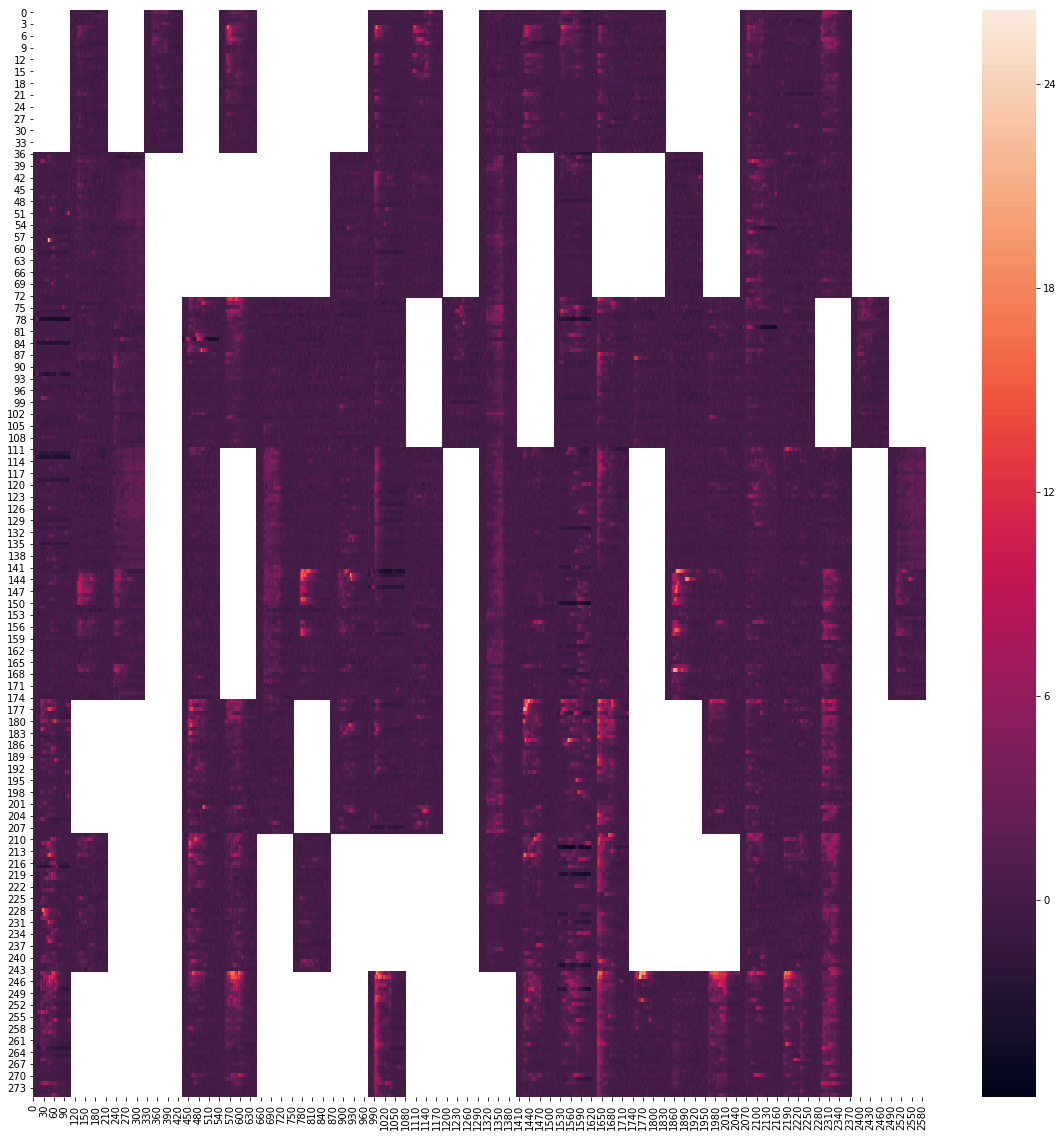

In [119]:
plt.figure(figsize=(20,20))
pboo = model_meta_list[0]['orientation'].isin([lookup['OA27']['plus']])
sns.heatmap(best_cells_list[0][10].reshape((24*108, 800)).T[pboo,:])

In [ ]:
plt.figure(figsize=(4,20))
pboo = meta_list[0]['orientation'].isin([lookup['OA27']['plus']])
sns.heatmap(np.nanmean(best_cells_list[0][10][:,:, pboo], axis=0).T)

# groups by component

In [339]:
# cs = 'plus'
# cs = 'minus'
# cs = 'neutral'


for c, meti in enumerate(meta_list):
    mi = mice[c]
    for ci in range(1, 11):
        # create axes
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(110, 100)
        ax1 = fig.add_subplot(gs[5:35,:])
        ax2 = fig.add_subplot(gs[40:70,:])
        ax3 = fig.add_subplot(gs[75:105,:])
        ax = [ax1, ax2, ax3]

        ylow = []
        yhigh = []
        for csn, cs in enumerate(['plus', 'minus', 'neutral']):
        #     c = 3
        #     ci = 1
        #     meti = meta_list[c]
            pboo = meti['orientation'].isin([lookup[mi][cs]]).values
            day_means = []
            day_vec = _new_day_vec(meti)
        #     for di in meti.reset_index()['date'].unique():
            for di in np.unique(day_vec):
        #         dboo = meti.reset_index()['date'].isin([di]).values
                dboo = np.isin(day_vec, di)
                dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & dboo], axis=2)
                day_means.append(dmean)


            stacked_means = np.hstack(day_means).T[:, :]
        #     plt.figure(figsize=(20,4))
            ax[csn].plot(stacked_means, alpha=0.5, color=color_dict[cs])
            ax[csn].plot(np.nanmean(stacked_means, axis=1), linewidth=3, color='black')
            ax[csn].set_ylabel('$\Delta$F/F (z-score)')
            if csn == 2:
                ax[csn].set_xlabel('response per day')
            if csn == 0:
                ax[csn].set_title('{}: component {} mean cell responses per day'.format(mi, ci))
            ax[csn].set_xlim([0, stacked_means.shape[0]])
            ylow.append(np.nanmin(stacked_means.flatten()))
            yhigh.append(np.nanmax(stacked_means.flatten()))
            sns.despine()

        yhigh = np.nanmax(yhigh)
        ylow = np.nanmin(ylow)
        for csn, cs in enumerate(['plus', 'minus', 'neutral']):    
            ax[csn].set_ylim([ylow, yhigh])
            
        # add lines for days and learning, reversal
        for csn, cs in enumerate(['plus', 'minus', 'neutral']):
            divinds = np.arange(len(np.unique(day_vec)))*108
            rev = True
            lea = True
            for dc, di in enumerate(np.unique(day_vec)):
                dboo = day_vec == di
                ls = np.unique(meti['learning_state'].iloc[dboo])
                if mi in ['OA32', 'OA34', 'OA36'] and dc == 0:
                    color=color_dict['learning']
                    linestyle='--'
                    linewidth=3
                    lea = False
                elif dc == 0:
                    continue
                elif ls == 'learning' and lea:
                    color=color_dict['learning']
                    linestyle='--'
                    linewidth=3
                    lea = False
                elif ls == 'reversal1' and rev:
                    color=color_dict['reversal']
                    linestyle='--'
                    linewidth=3
                    rev = False
                else:
                    color=color_dict['gray']
                    linestyle='-'
                    linewidth=2
                x1 = divinds[dc]
                ax[csn].plot([x1, x1], [ylow, yhigh], color=color, linestyle=linestyle, linewidth=linewidth, alpha=0.7)
            
        line1 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['plus'])
        line2 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['minus'])
        line3 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['neutral'])
        line4 = lines.Line2D([], [], linewidth=4, linestyle="-", color='black')
        line5 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['learning'])
        line6 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['reversal'])
        line7 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['gray'])
        label_lines = [line4, line1, line2, line3, line5, line6, line7]
        labels = ['mean response', 'individual cell responses', 'individual cell responses', 'individual cell responses',
                 'learning starts', 'reversal starts', 'days']
        ax[0].legend(label_lines, labels, bbox_to_anchor=(1.05, 1))
        plt.savefig('.//Mean daily responses by comp group//{}_component{}_mean_response_alltime.png'.format(mi, ci), bbox_inches='tight')
        plt.close('all')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


# cells by day

In [340]:
# cs = 'plus'
# cs = 'minus'
# cs = 'neutral'


for c, meti in enumerate(meta_list):
    mi = mice[c]
    for ci in range(1, 11):
        for celli in range(best_cells_list[c][ci].shape[0]):
            # create axes
            fig = plt.figure(figsize=(15, 10))
            gs = fig.add_gridspec(110, 100)
            ax1 = fig.add_subplot(gs[5:35,:])
            ax2 = fig.add_subplot(gs[40:70,:])
            ax3 = fig.add_subplot(gs[75:105,:])
            ax = [ax1, ax2, ax3]
            ylow = []
            yhigh = []
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):
            #     c = 3
            #     ci = 1
            #     meti = meta_list[c]
                pboo = meti['orientation'].isin([lookup[mi][cs]]).values
                day_means = []
                day_vec = _new_day_vec(meti)
            #     for di in meti.reset_index()['date'].unique():
                for di in np.unique(day_vec):
            #         dboo = meti.reset_index()['date'].isin([di]).values
                    dboo = np.isin(day_vec, di)
                    dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & dboo], axis=2)
                    day_means.append(dmean)


                stacked_means = np.hstack(day_means).T[:, celli]
            #     plt.figure(figsize=(20,4))
                ax[csn].plot(stacked_means, alpha=0.5, linewidth=2, color=color_dict[cs])
#                 ax[csn].plot(np.nanmean(stacked_means, axis=1), linewidth=3, color='black')
                ax[csn].set_ylabel('$\Delta$F/F (z-score)')
                if csn == 2:
                    ax[csn].set_xlabel('response per day')
                if csn == 0:
                    ax[csn].set_title('{}: component {}: cell {} mean cell responses per day'.format(mi, ci, celli))
                ax[csn].set_xlim([0, stacked_means.shape[0]])
                ylow.append(np.nanmin(stacked_means.flatten()))
                yhigh.append(np.nanmax(stacked_means.flatten()))
                sns.despine()

            yhigh = np.nanmax(yhigh)
            ylow = np.nanmin(ylow)
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):    
                ax[csn].set_ylim([ylow, yhigh])

            # add lines for days and learning, reversal
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):
                divinds = np.arange(len(np.unique(day_vec)))*108
                rev = True
                lea = True
                for dc, di in enumerate(np.unique(day_vec)):
                    dboo = day_vec == di
                    ls = np.unique(meti['learning_state'].iloc[dboo])
                    if mi in ['OA32', 'OA34', 'OA36'] and dc == 0:
                        color=color_dict['learning']
                        linestyle='--'
                        linewidth=3
                        lea = False
                    elif dc == 0:
                        continue
                    elif ls == 'learning' and lea:
                        color=color_dict['learning']
                        linestyle='--'
                        linewidth=3
                        lea = False
                    elif ls == 'reversal1' and rev:
                        color=color_dict['reversal']
                        linestyle='--'
                        linewidth=3
                        rev = False
                    else:
                        color=color_dict['gray']
                        linestyle='-'
                        linewidth=2
                    x1 = divinds[dc]
                    ax[csn].plot([x1, x1], [ylow, yhigh], color=color, linestyle=linestyle, linewidth=linewidth, alpha=0.7)

            line1 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['plus'])
            line2 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['minus'])
            line3 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['neutral'])
#             line4 = lines.Line2D([], [], linewidth=4, linestyle="-", color='black')
            line5 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['learning'])
            line6 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['reversal'])
            line7 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['gray'])
            label_lines = [line1, line2, line3, line5, line6, line7]
            labels = ['initial FC responses', 'initial QC responses', 'initial NC responses',
                     'learning starts', 'reversal starts', 'days']
            ax[0].legend(label_lines, labels, bbox_to_anchor=(1.05, 1))
            plt.savefig('.//Mean daily responses by comp group cells//{}_component{}_cell{}_mean_response_alltime.png'.format(mi, ci, celli), bbox_inches='tight')
            plt.close('all')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


# cells by stage

In [382]:
# cs = 'plus'
# cs = 'minus'
# cs = 'neutral'
dp_threshold = 2

for c, meti in enumerate(meta_list):
    mi = mice[c]
    meti = cas.utils.add_dprime_to_meta(meti)
    for ci in range(1, 11):
        for celli in range(best_cells_list[c][ci].shape[0]):
            # create axes
            fig = plt.figure(figsize=(15, 10))
            gs = fig.add_gridspec(110, 100)
            ax1 = fig.add_subplot(gs[5:35,:])
            ax2 = fig.add_subplot(gs[40:70,:])
            ax3 = fig.add_subplot(gs[75:105,:])
            ax = [ax1, ax2, ax3]
            ylow = []
            yhigh = []
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):
            #     c = 3
            #     ci = 1
            #     meti = meta_list[c]
                pboo = meti['orientation'].isin([lookup[mi][cs]]).values
                day_means = []
#                 day_vec = _new_day_vec(meti)
            
                stage_labels = []
                c_day = 0
                for n_stage in meta_list[0]['learning_state'].unique(): # forcing to include all stages
                    meti_d = meti
                    stage_bool = meti_d['learning_state'].isin([n_stage]).values
                    if n_stage == 'naive':
                        total_bool = stage_bool #& (y_vec < 1)
                        stage_labels.append(n_stage)
                        dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & total_bool], axis=2)
                        if len(dmean) == 0:
                            dmean = np.zeros(108)
                            dmean[:] = np.nan
                        day_means.append(dmean)
                    elif n_stage == 'learning':
                        for dpi in ['low_dp learning', 'high_dp learning']:
                            if 'high_dp' in dpi:
                                dp_bool = meti_d['dprime'].values >= dp_threshold
                            elif 'low_dp' in dpi:
                                dp_bool = meti_d['dprime'].values < dp_threshold
                            total_bool = stage_bool & dp_bool #& (y_vec < 1) #& ori_bool
                            stage_labels.append(dpi)
                            dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & total_bool], axis=2)
                            if len(dmean) == 0:
                                dmean = np.zeros(108)
                                dmean[:] = np.nan
                            day_means.append(dmean)
                    elif n_stage == 'reversal1':
                        for dpi in ['low_dp reversal', 'high_dp reversal']:
                            if 'high_dp' in dpi:
                                dp_bool = meti_d['dprime'].values >= dp_threshold
                            elif 'low_dp' in dpi:
                                dp_bool = meti_d['dprime'].values < dp_threshold
                            total_bool = stage_bool & dp_bool #& (y_vec < 1) #& ori_bool
                            stage_labels.append(dpi)
                            dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & total_bool], axis=2)
                            if len(dmean) == 0:
                                dmean = np.zeros(108)
                                dmean[:] = np.nan
                            day_means.append(dmean)
                        
#                 for di in np.unique(day_vec):
#             #         dboo = meti.reset_index()['date'].isin([di]).values
#                     dboo = np.isin(day_vec, di)
#                     dmean = np.nanmean(best_cells_list[c][ci][:,:, pboo & dboo], axis=2)
#                     day_means.append(dmean)


                stacked_means = np.hstack(day_means).T[:, celli]
            #     plt.figure(figsize=(20,4))
                ax[csn].plot(stacked_means, alpha=0.5, linewidth=2, color=color_dict[cs])
#                 ax[csn].plot(np.nanmean(stacked_means, axis=1), linewidth=3, color='black')
                ax[csn].set_ylabel('$\Delta$F/F (z-score)', size=16)
                if csn == 2:
                    ax[csn].set_xlabel('\nresponse per stage', size=16)
                if csn == 0:
                    ax[csn].set_title('{}: component {}: cell {} mean cell responses per learning stage\n'.format(mi, ci, celli), size=18)
                ax[csn].set_xlim([0, stacked_means.shape[0]])
                ylow.append(np.nanmin(stacked_means.flatten()))
                yhigh.append(np.nanmax(stacked_means.flatten()))
                sns.despine()

            yhigh = np.nanmax(yhigh)
            ylow = np.nanmin(ylow)
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):    
                ax[csn].set_ylim([ylow, yhigh])
#                 ax[csn].set_yticks(ax[csn].get_yticks())
#                 ax[csn].set_yticklabels([s.get_text() for s in ax[csn].get_yticklabels()], size=14)

            # add lines for days and learning, reversal
            for csn, cs in enumerate(['plus', 'minus', 'neutral']):
                divinds = np.arange(len(np.unique(stage_labels)))*108
                rev = True
                lea = True
                for dc, di in enumerate(stage_labels):
                    dboo = np.array(stage_labels) == di
                    if mi in ['OA32', 'OA34', 'OA36'] and dc == 0:
                        color=color_dict['learning']
                        linestyle='--'
                        linewidth=3
                        lea = False
                    elif dc == 0:
                        continue
                    elif di == 'low_dp learning' and lea:
                        color=color_dict['learning']
                        linestyle='--'
                        linewidth=3
                        lea = False
                    elif di == 'low_dp reversal' and rev:
                        color=color_dict['reversal']
                        linestyle='--'
                        linewidth=3
                        rev = False
                    else:
                        color=color_dict['gray']
                        linestyle='-'
                        linewidth=2
                    x1 = divinds[dc]
                    ax[csn].plot([x1, x1], [ylow, yhigh], color=color, linestyle=linestyle, linewidth=linewidth, alpha=0.7)
                    ax[csn].set_xticks([])
                    ax[csn].set_xlim([0, 108*5])

            line1 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['plus'])
            line2 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['minus'])
            line3 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['neutral'])
#             line4 = lines.Line2D([], [], linewidth=4, linestyle="-", color='black')
            line5 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['learning'])
            line6 = lines.Line2D([], [], linewidth=3, linestyle="--", color=color_dict['reversal'])
            line7 = lines.Line2D([], [], linewidth=2, linestyle="-", color=color_dict['gray'])
            label_lines = [line1, line2, line3, line5, line6, line7]
            labels = ['initial FC responses', 'initial QC responses', 'initial NC responses',
                     'learning starts', 'reversal starts', 'days']
            ax[0].legend(label_lines, labels, bbox_to_anchor=(1.05, 1))
            ax[2].set_xticks(divinds+108/2)
            ax[2].set_xticklabels(labels=stage_labels, size=14)
            plt.savefig('.//Mean stage responses by comp group cells//{}_component{}_cell{}_mean_response_alltime.png'.format(mi, ci, celli), bbox_inches='tight')
            plt.close('all')
#             break
#         break
#     break

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


In [376]:
[s.get_text() for s in ax[csn].get_yticklabels()]

['-0.4', '-0.2', '0.0', '0.20000000000000007', '0.4', '0.6']

In [ ]:
stacked_means = np.hstack(day_means).T[:, :]
plt.figure(figsize=(20,4))
plt.plot(stacked_means, alpha=0.5, color=color_dict['minus'])
plt.plot(np.nanmean(stacked_means, axis=1), linewidth=3, color='black')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


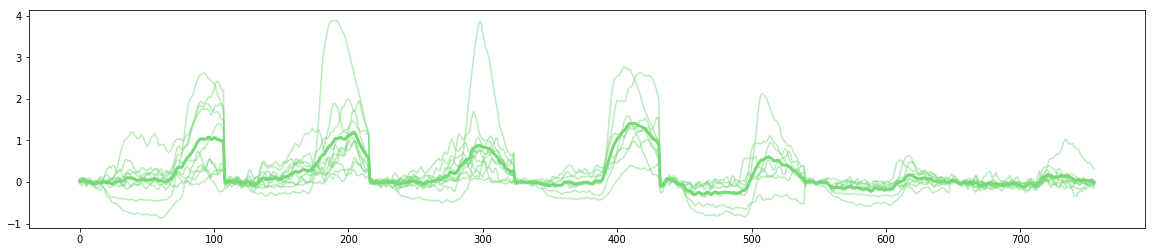

In [65]:
for c, meti in enumerate(model_meta_list):
    mi = mice[c]
    pboo = meti['orientation'].isin([lookup[mi]['plus']]).values
    day_means = []
    for di in meti.reset_index()['date'].unique():
        dboo = meti.reset_index()['date'].isin([di]).values
        dmean = np.nanmean(best_cells_list[0][7][:,:, pboo & dboo], axis=2)
        day_means.append(dmean)
    break
    
stacked_means = np.hstack(day_means).T[:, :]
plt.figure(figsize=(20,4))
plt.plot(stacked_means, alpha=0.5, color=color_dict['plus'])
plt.plot(np.nanmean(stacked_means, axis=1), linewidth=3, color=color_dict['plus'])

In [240]:
teni = model_tensor_list[0]
meti = model_meta_list[0]
mi = mice[0]

day_means = []
day_vec = _new_day_vec(meti)
pre_post = []
for di in np.unique(day_vec)[3:5]:
    dboo = np.isin(day_vec, di)
    pmn = []
    for csn, cs in enumerate(['plus', 'minus', 'neutral']):
        pboo = meti['orientation'].isin([lookup[mi][cs]]).values
        mean_vec = np.nanmean(teni[:, :, dboo & pboo], axis=2)
        pmn.append(mean_vec)
    pre_post.append(pmn)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [ ]:
g = sns.clustermap(cells_prepost_diff[:, -108:], col_cluster=False, vmax=6)
row_sorter = g.dendrogram_row.reordered_ind

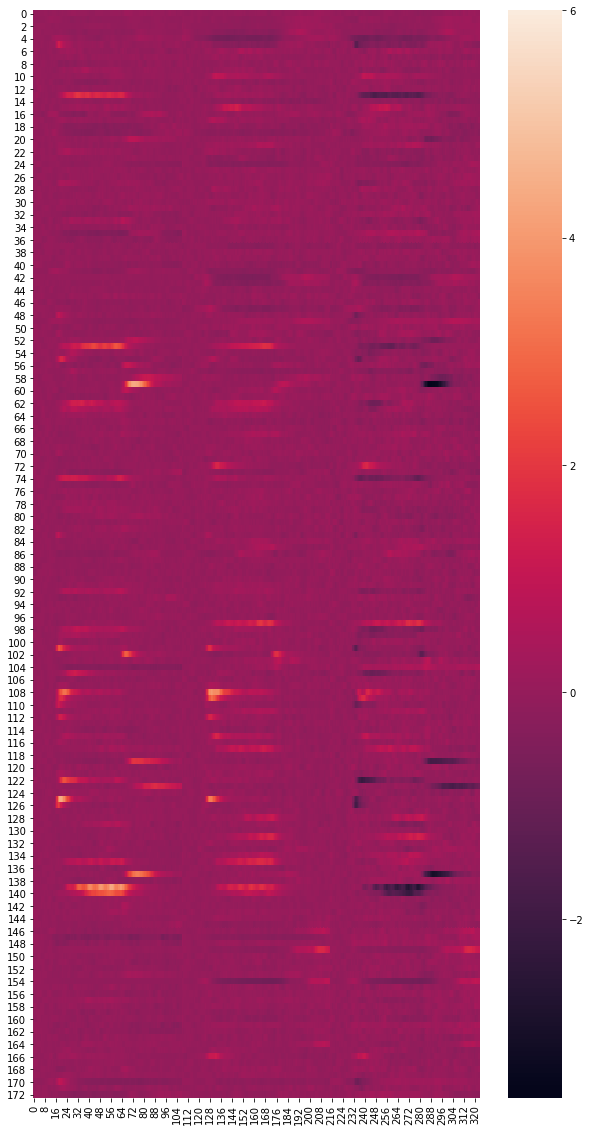

In [252]:
stimn = 1
cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
cells_prepost = np.hstack([pre_post[0][stimn], pre_post[1][stimn]])[cell_vec, :]
cells_prepost_diff = np.hstack([pre_post[0][stimn], pre_post[1][stimn], pre_post[1][stimn]-pre_post[0][stimn]])[cell_vec, :]
peaksort = np.argsort(np.argmax(cells_prepost[:, 15:108], axis=1))
plt.figure(figsize=(10,20))
# sns.heatmap(cells_prepost[peaksort, :])
sns.heatmap(cells_prepost_diff[row_sorter, :], vmax=6)
# sns.heatmap(np.hstack([pre_post[0][0], pre_post[1][0], pre_post[1][0]-pre_post[0][0]])[cell_vec, :])
# teni.shape

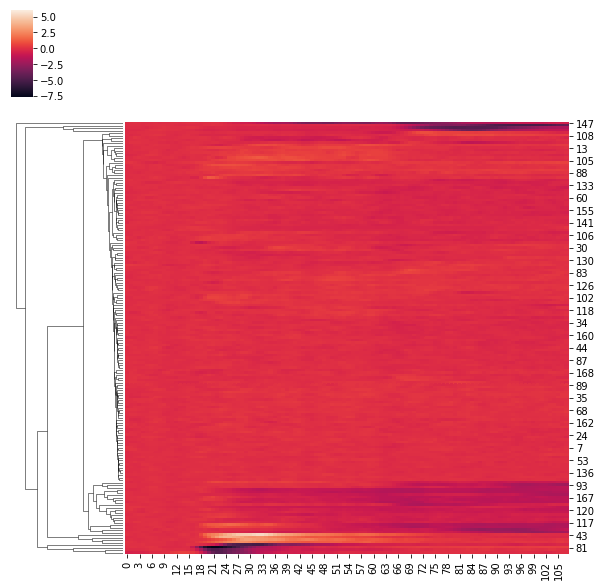

In [249]:
g = sns.clustermap(cells_prepost_diff[:, -108:], col_cluster=False, vmax=6)
row_sorter = g.dendrogram_row.reordered_ind

In [225]:
day_vec = _new_day_vec(meta_list[0])
pre_post = []
# for di in np.unique(day_vec)[3:5]:
#     dboo = np.isin(day_vec, di)

In [226]:
# tensor_list[0]
np.unique(day_vec)

array([170116. , 170118. , 170119. , 170204. , 170206. , 170207. ,
       170208. , 170209. , 170210. , 170211. , 170214. , 170215. ,
       170216. , 170217. , 170220. , 170223. , 170224. , 170303. ,
       170308. , 170318. , 170318.5, 170320. , 170321. , 170322. ,
       170323. , 170326. , 170328. , 170403. , 170404. ])

In [253]:
teni = tensor_list[0]
meti = meta_list[0]
mi = mice[0]

day_means = []
day_vec = _new_day_vec(meti)
pre_post = []
counter = 0
for di in [170318. , 170318.5]:
    dboo = np.isin(day_vec, di)
    dboo2 = np.zeros(len(dboo))
    if counter == 0:
        dboo_inds = np.where(dboo)[-100:]
        counter += 1
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    else:
        dboo_inds = np.where(dboo)[0][:100]
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    pmn = []
    for csn, cs in enumerate(['plus', 'minus', 'neutral']):
        pboo = meti['orientation'].isin([lookup[mi][cs]]).values
#         mean_vec = np.nanmean(teni[:, :, dboo & pboo], axis=2)
        mean_vec = np.nanmean(teni[:, :, dboo2 & pboo], axis=2)
        pmn.append(mean_vec)
    pre_post.append(pmn)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


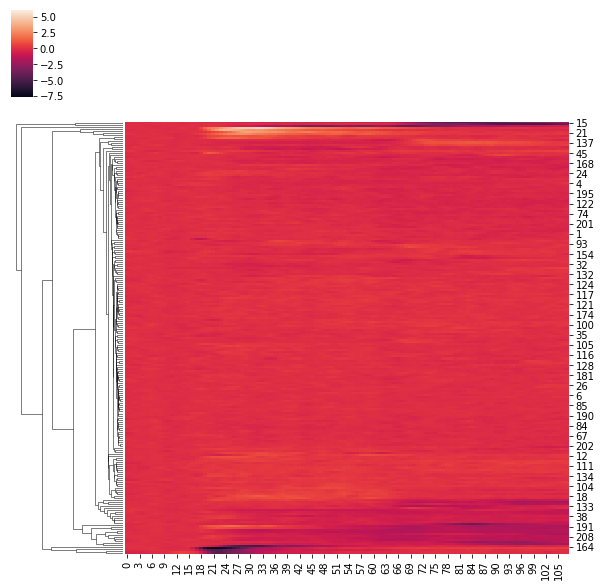

In [255]:
g = sns.clustermap(cells_prepost_diff[:, -108:], col_cluster=False, vmax=6)
row_sorter = g.dendrogram_row.reordered_ind

In [ ]:
stimn = 0
cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
cells_prepost = np.hstack([pre_post[0][stimn], pre_post[1][stimn]])[cell_vec, :]
cells_prepost_diff = np.hstack([pre_post[0][stimn], pre_post[1][stimn], pre_post[1][stimn]-pre_post[0][stimn]])[cell_vec, :]
peaksort = np.argsort(np.argmax(cells_prepost[:, 15:108], axis=1))
plt.figure(figsize=(10,20))
# sns.heatmap(cells_prepost[peaksort, :])
sns.heatmap(cells_prepost_diff[row_sorter, :])
# sns.heatmap(np.hstack([pre_post[0][0], pre_post[1][0], pre_post[1][0]-pre_post[0][0]])[cell_vec, :])
# teni.shape

In [259]:

# stack all of your pre post matrices
pmn_stack = []
for stimn in range(3):
    cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
    cells_prepost = np.hstack([pre_post[0][stimn], pre_post[1][stimn]])[cell_vec, :]
    cells_prepost_diff = np.hstack([pre_post[0][stimn], pre_post[1][stimn], pre_post[1][stimn]-pre_post[0][stimn]])[cell_vec, :]
    pmn_stack.append(cells_prepost_diff[:,:,None])
pmn_stack = np.concatenate(pmn_stack, axis=2)


In [284]:
# sorter for cue preference
pmn_vec = []
for stimn in range(3):
    cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
    pmn_vec.append(pre_post[0][stimn][cell_vec, :])
sorterup, sorterdown = pref_cue_sorter(pmn_vec[0], pmn_vec[1], pmn_vec[2])

In [285]:
# stack all of your pre post matrices
pp_pmn_6vec = []
for stimn in range(3):
    cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
    pp_pmn_6vec.append(np.hstack([pre_post[0][stimn], pre_post[1][stimn]])[cell_vec, :])
pp_heat = np.hstack(pp_pmn_6vec)

In [294]:
# stack all of your pre post matrices
pp_pmn_6list = []
for stimn in range(3):
    cell_vec = ~np.isnan(pre_post[0][stimn][:,0])
    pp_pmn_6list.append(pre_post[0][stimn][cell_vec, :])
    pp_pmn_6list.append(pre_post[1][stimn][cell_vec, :])
sorterup, sorterdown = pref_cue_sorter_flip(pp_pmn_6list[0], pp_pmn_6list[2], pp_pmn_6list[4], pp_pmn_6list[1], pp_pmn_6list[3], pp_pmn_6list[5])

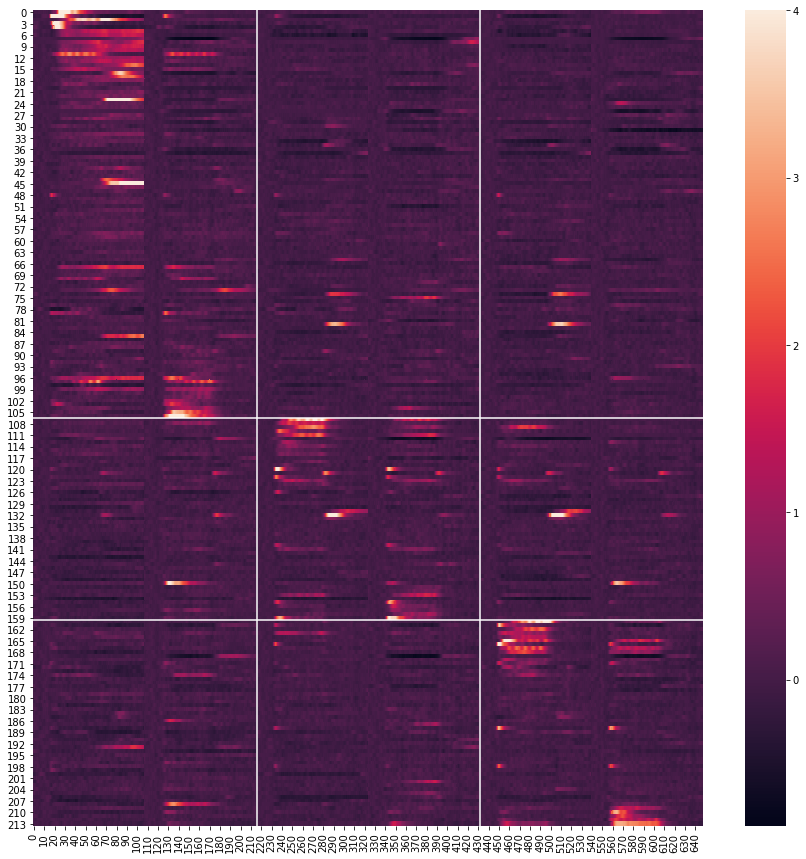

In [403]:
plt.figure(figsize=(15,15))
sns.heatmap(pp_heat[sorterup, :], vmax=4)
plt.plot([0, 108*6], [107, 107], color='white')
plt.plot([0, 108*6], [160, 160], color='white')
plt.plot([108*2, 108*2], [0, 214], color='white')
plt.plot([108*4, 108*4], [0, 214], color='white')

In [338]:
cellz = 0
for i in tensor_list:
    cellnum = i.shape[0]
    print(cellnum)
    cellz += cellnum
print(cellz)

616
305
498
464
394
301
703
3281


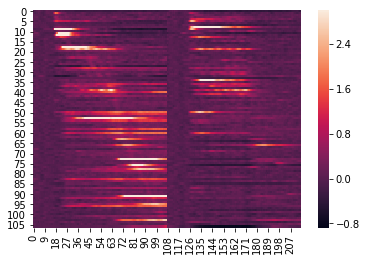

In [406]:
# plt.plot(pp_heat[sorterup, :][0:107, 0:108*2].T)
just_plus = deepcopy(pp_heat[sorterup, :][0:107, 0:108*2])
jp_max = np.max(just_plus, axis=1)
before_max = np.argmax(just_plus[:, 0:108], axis=1)
after_max = np.argmax(just_plus[:, 108:], axis=1)
sns.heatmap(just_plus[np.argsort(before_max), :], vmax=3)
# plt.plot(pp_heat[sorterup, :].T)
# plt.plot(np.nanmean(pp_heat, axis=0).T, linewidth=4, color='black')

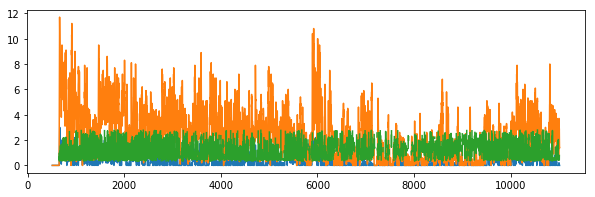

In [416]:
plt.figure(figsize=(10, 3))
plt.plot(meti['pre_licks'].rolling(10).mean().values)
plt.plot(meti['anticipatory_licks'].rolling(10).mean().values)
plt.plot(meti['firstlickbout'].values/50)

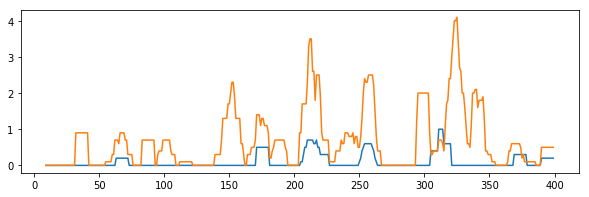

In [421]:
plt.figure(figsize=(10, 3))
plt.plot(meti['pre_licks'].iloc[7800:8200].rolling(10).mean().values)
plt.plot(meti['anticipatory_licks'].iloc[7800:8200].rolling(10).mean().values)
plt.plot(meti['firstlickbout'].iloc[7800:8200].rolling(1000).min().values/50)

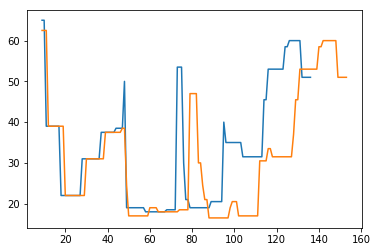

In [425]:
plt.plot(meti['firstlickbout'].iloc[7800:8200].dropna().rolling(10).min().values)
plt.plot(meti['firstlick'].iloc[7800:8200].dropna().rolling(10).min().values)

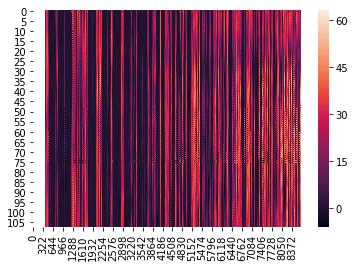

In [432]:
sns.heatmap(bhv_list[0][2,:,:])

In [16]:
# np.unique(_new_day_vec(meti))
teni = tensor_list[0]
meti = meta_list[0]
mi = mice[0]
meti.head()

orientation condition  trialerror  prev_reward  \
mouse date   run trial_idx                                                   
OA27  170116 3   0                    0   neutral         3.0        False   
                 1                  135     minus         4.0        False   
                 2                  270      plus         0.0        False   
                 3                    0   neutral         3.0        False   
                 4                  135     minus         4.0        False   

                            prev_punish  hunger learning_state       tag  \
mouse date   run trial_idx                                                 
OA27  170116 3   0                False  hungry          naive  standard   
                 1                False  hungry          naive  standard   
                 2                False  hungry          naive  standard   
                 3                False  hungry          naive  standard   
                 4                False  hungry          naive  standard   

                            firstlick  firstlickbout  ensure  quinine  speed  \
mouse date   run trial_idx                                                     
OA27  170116 3   0                NaN            NaN     NaN      NaN    NaN   
                 1                NaN            NaN     NaN      NaN    NaN   
                 2                NaN            NaN     NaN      NaN    NaN   
                 3                NaN            NaN     NaN      NaN    NaN   
                 4                NaN            NaN     NaN      NaN    NaN   

                            pre_speed  anticipatory_licks  pre_licks  pupil  \
mouse date   run trial_idx                                                    
OA27  170116 3   0                NaN                 NaN        NaN    NaN   
                 1                NaN                 NaN        NaN    NaN   
                 2                NaN                 NaN        NaN    NaN   
                 3                NaN                 NaN        NaN    NaN   
                 4                NaN                 NaN        NaN    NaN   

                            pre_pupil  brainmotion  
mouse date   run trial_idx                          
OA27  170116 3   0                NaN          NaN  
                 1                NaN          NaN  
                 2                NaN          NaN  
                 3                NaN          NaN  
                 4                NaN          NaN

5483


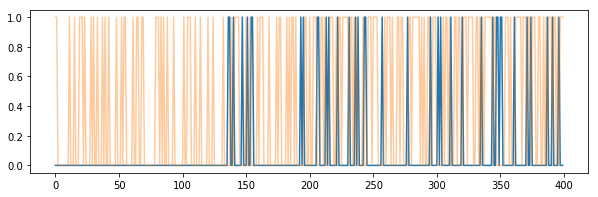

In [32]:

rev_ind = np.where(meti['learning_state'].isin(['reversal1']).values)[0][0]
print(rev_ind)

ind_before = 200
ind_after = 200
plt.figure(figsize=(10, 3))
plt.plot(meti['prev_punish'].iloc[rev_ind-ind_before:rev_ind+ind_after].values)
plt.plot(meti['prev_reward'].iloc[rev_ind-ind_before:rev_ind+ind_after].values, alpha=0.4)

In [41]:
# get the mean response for 9 conditions: p m n preceded by reward. p m n preceded by quinine. p m n preceded by no outcome. 

# get inputs, ready to be for looped 
teni = tensor_list[0]
meti = meta_list[0]
mi = mice[0]

# get indices to focus on reversal period
rev_ind = np.where(meti['learning_state'].isin(['reversal1']).values)[0][0]
ind_before = 0
ind_after = 200

# get outcome booleans
punboo = meti['prev_punish'].iloc[rev_ind-ind_before:rev_ind+ind_after].values
rewboo = meti['prev_reward'].iloc[rev_ind-ind_before:rev_ind+ind_after].values
nooboo = ~(rewboo | punboo)
boo_dict = {'prev_punish': punboo, 'prev_reward': rewboo, 'no_outcome': nooboo}

# subset tensor to match booleans
subten = teni[:, :, rev_ind-ind_before:rev_ind+ind_after]

# loop over CSs and outcome booleans
cell_avgs_by_cs_prevoutcome = {}
for csn, cs in enumerate(['plus', 'minus', 'neutral']):
    cell_avgs_by_cs_prevoutcome[cs] = {}
    csboo = meti['orientation'].iloc[rev_ind-ind_before:rev_ind+ind_after].isin([lookup[mi][cs]]).values
    for ki in boo_dict.keys():
        outcome_boo = boo_dict[ki] & csboo
        cell_avgs_by_cs_prevoutcome[cs][ki] = np.nanmean(subten[:, :, outcome_boo], axis=2)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


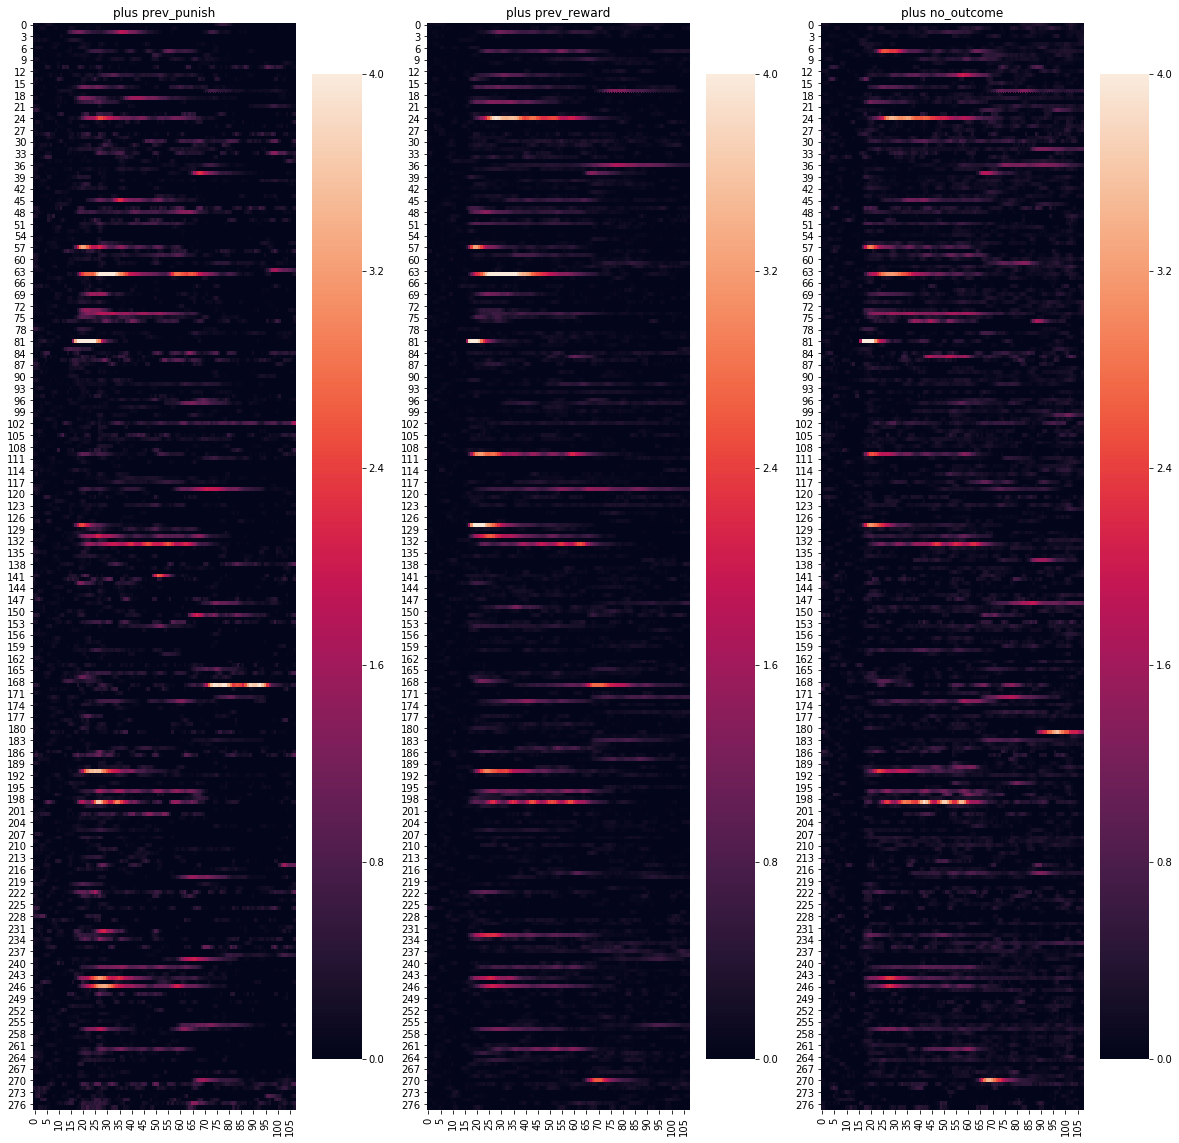

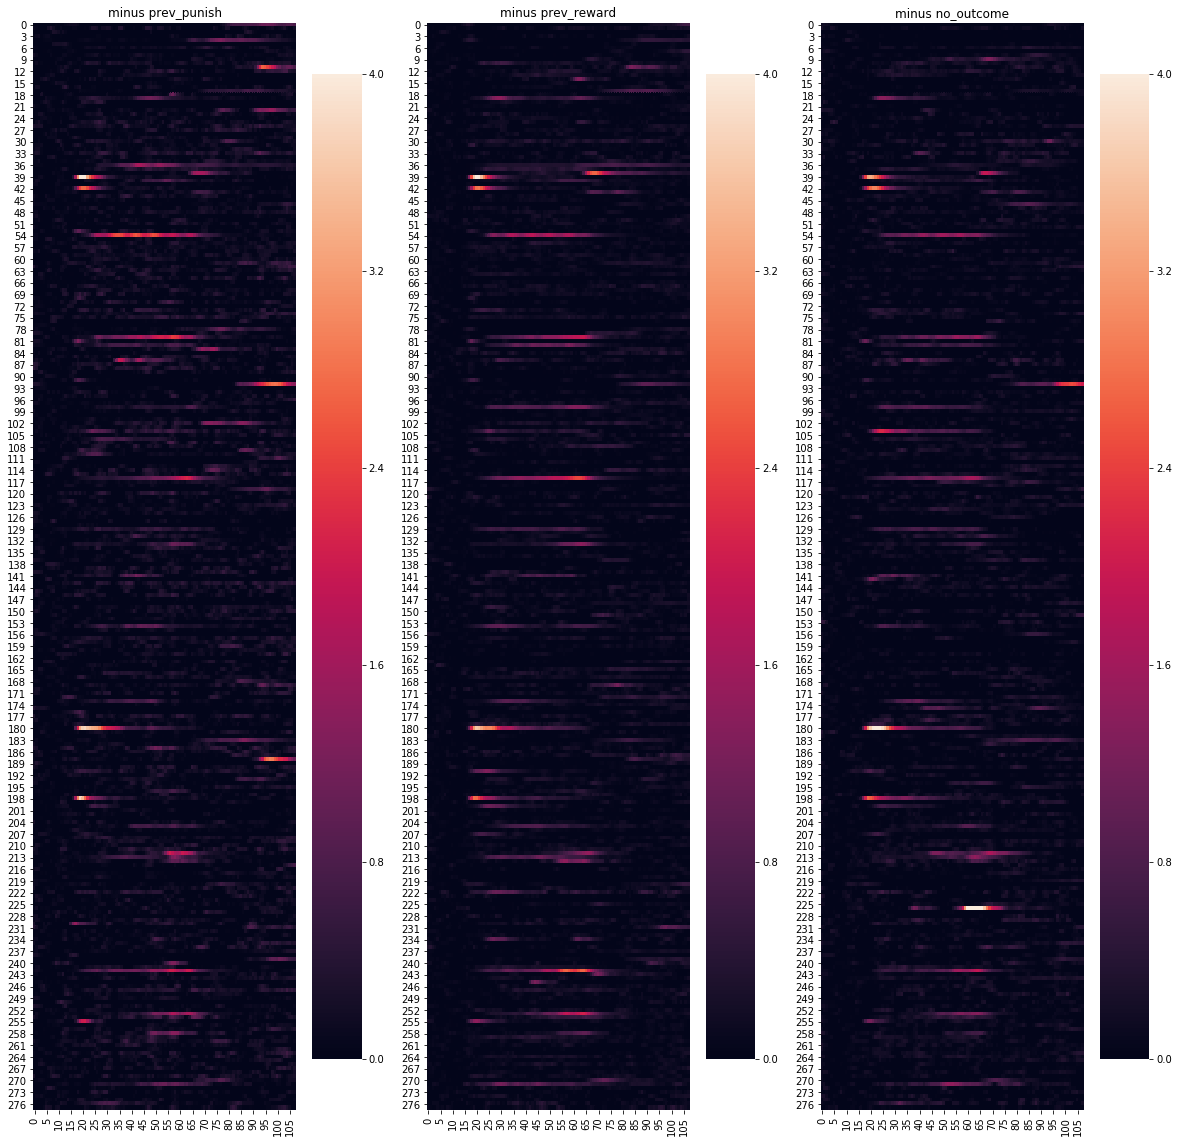

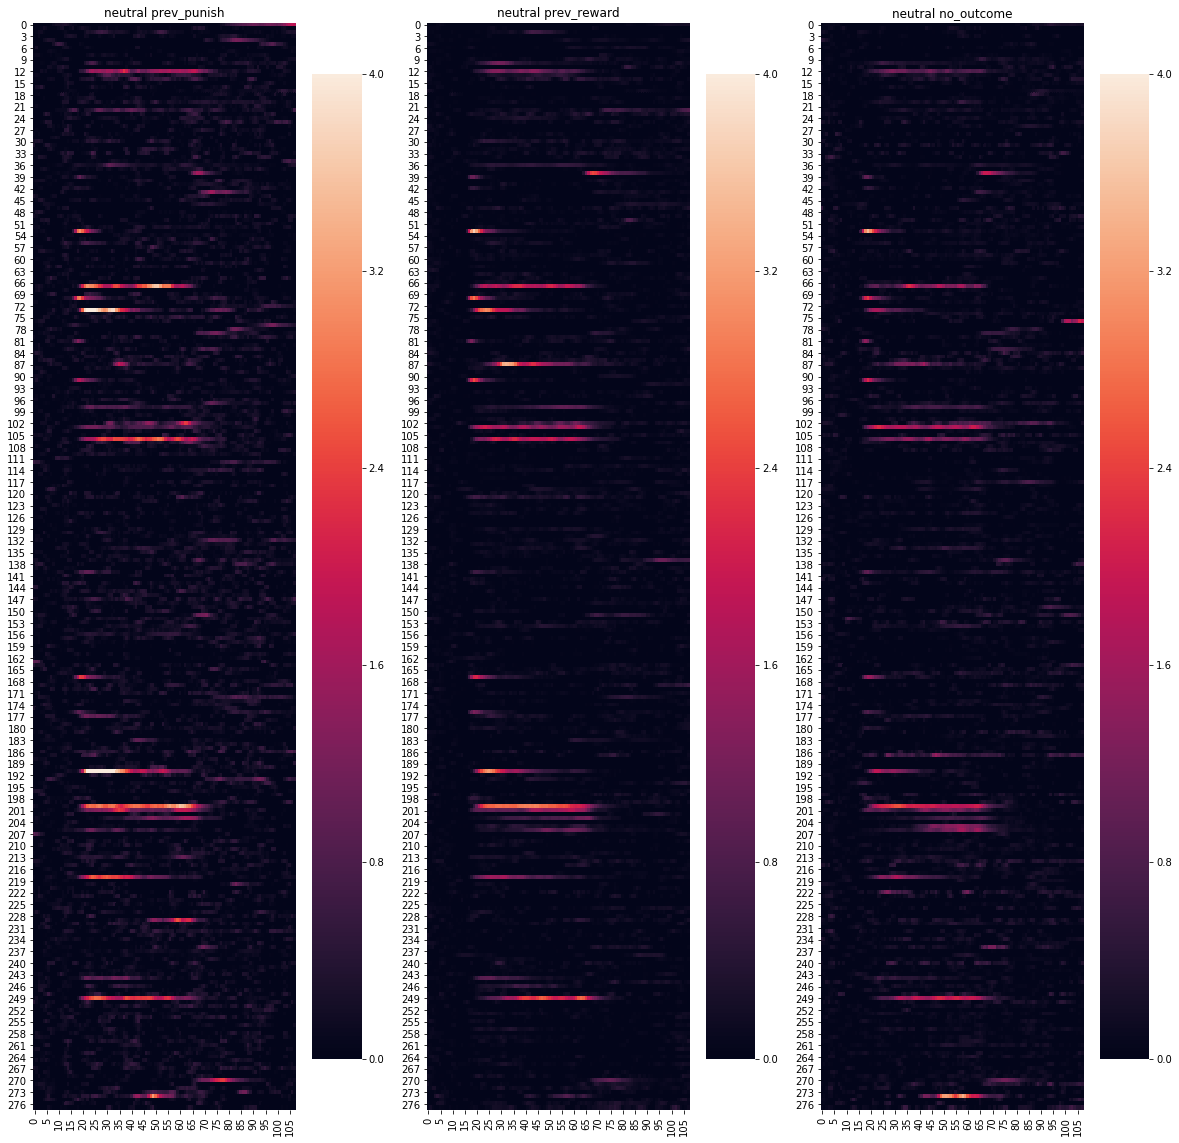

In [43]:
for csn, cs in enumerate(['plus', 'minus', 'neutral']):
    f, axes = plt.subplots(1, 3, figsize=(20, 20))
    for cki, ki in enumerate(boo_dict.keys()):
        axes[cki].set_title('{} {}'.format(cs, ki))
        cells = cell_avgs_by_cs_prevoutcome[cs][ki]
        not_nan = ~np.isnan(cells[:,0])
        good_cells = cells[not_nan, :]
        sns.heatmap(good_cells, ax=axes[cki], vmin=0, vmax=4)

In [ ]:
teni = tensor_list[0]
meti = meta_list[0]
mi = mice[0]

hits = meti['trialerror'].values == 0

following_reward
day_means = []
day_vec = _new_day_vec(meti)
pre_post = []
counter = 0
for di in [170318.5]:
    dboo = np.isin(day_vec, di)
    dboo2 = np.zeros(len(dboo))
    if counter == 0:
        dboo_inds = np.where(dboo)[-100:]
        counter += 1
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    else:
        dboo_inds = np.where(dboo)[0][:100]
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    pmn = []
    for csn, cs in enumerate(['plus', 'minus', 'neutral']):
        pboo = meti['orientation'].isin([lookup[mi][cs]]).values
#         mean_vec = np.nanmean(teni[:, :, dboo & pboo], axis=2)
        mean_vec = np.nanmean(teni[:, :, dboo2 & pboo], axis=2)
        pmn.append(mean_vec)
    pre_post.append(pmn)

In [439]:
output = cas.psytrack.train_factor.sync_tca_pillow(
        'OA27',
        trace_type='zscore_day',
        method='ncp_hals',
        cs='',
        warp=False,
        word='prints',
        group_by='all2',
        nan_thresh=0.85,
        score_threshold=0.8,
        rank_num=10,
        fixed_sigma=None,
        fixed_sigma_day=None,
        verbose=True)

Saved PsyTracker found, loading: S:\twophoton_analysis\Data\output\psytrack\OA27\caused\OA27_caused_santa.psy
Updated naive cs-ori pairings to match learning.
     270 plus
     135 minus
     0 neutral
Updated naive trialerror to match learning.


In [463]:
inten = cas.load.groupday_tca_input_tensor(
        'OA27',
        trace_type='zscore_day',
        method='ncp_hals',
        cs='',
        warp=False,
        word='prints',
        group_by='all2',
        nan_thresh=0.85,
        score_threshold=0.8)

In [469]:
# psy1.index.isin([meti.index])
# len(psy1['prev_reward_input'])
day_vec = _new_day_vec(meti)
np.unique(day_vec)

array([170208. , 170209. , 170213. , 170214. , 170215. , 170217. ,
       170219. , 170220. , 170221. , 170223. , 170224. , 170308. ,
       170309. , 170313. , 170314. , 170317. , 170319. , 170319.5,
       170320. , 170321. , 170322. , 170324. , 170325. , 170327. ,
       170328. , 170330. , 170401. , 170402. , 170403. , 170404. ,
       170405. , 170412. , 170424. ])

In [480]:
test = np.array([0, 1, 0], dtype=float)
test = np.insert(test, 0, np.nan)
test

array([nan,  0.,  1.,  0.])

orientation condition  trialerror  hunger  \
mouse date   run trial_idx                                              
OA26  170208 1   0                  270      plus         1.0  hungry   
                 1                  270      plus         1.0  hungry   
                 2                    0   neutral         2.0  hungry   
                 3                    0   neutral         2.0  hungry   
                 4                  135     minus         4.0  hungry   

                           learning_state       tag  firstlick  firstlickbout  \
mouse date   run trial_idx                                                      
OA26  170208 1   0                  naive  standard        NaN            NaN   
                 1                  naive  standard        NaN            NaN   
                 2                  naive  standard        NaN            NaN   
                 3                  naive  standard        NaN            NaN   
                 4                  naive  standard        NaN            NaN   

                            ensure  quinine      speed  pre_speed  \
mouse date   run trial_idx                                          
OA26  170208 1   0             NaN      NaN   0.000000   0.000000   
                 1             NaN      NaN   0.000000   0.000000   
                 2             NaN      NaN   0.000000   0.000000   
                 3             NaN      NaN  21.419649  23.491501   
                 4             NaN      NaN   7.826901  20.269073   

                            anticipatory_licks  pre_licks  pupil  pre_pupil  \
mouse date   run trial_idx                                                    
OA26  170208 1   0                         NaN        NaN    NaN        NaN   
                 1                         NaN        NaN    NaN        NaN   
                 2                         NaN        NaN    NaN        NaN   
                 3                         NaN        NaN    NaN        NaN   
                 4                         NaN        NaN    NaN        NaN   

                            brainmotion  dprime  
mouse date   run trial_idx                       
OA26  170208 1   0             0.000000     0.0  
                 1             0.000000     0.0  
                 2             0.000000     0.0  
                 3            21.419649     0.0  
                 4             7.826901     0.0

In [ ]:
prewboo = psy1['prev_reward_input'].values > 0
rev1boo = met1['learning_state'].isin['reversal1'].values
hits = met1['trialerror'].values == 0

day_means = []
day_vec = _new_day_vec(met1)
pre_post = []
counter = 0
for di in [170318.5]:
    dboo = np.isin(day_vec, di)
    dboo2 = np.zeros(len(dboo))
    if counter == 0:
        dboo_inds = np.where(dboo)[-100:]
        counter += 1
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    else:
        dboo_inds = np.where(dboo)[0][:100]
        dboo2[dboo_inds] = 1
        dboo2 = dboo2 > 0
    pmn = []
    for csn, cs in enumerate(['plus', 'minus', 'neutral']):
        pboo = meti['orientation'].isin([lookup[mi][cs]]).values
#         mean_vec = np.nanmean(teni[:, :, dboo & pboo], axis=2)
        mean_vec = np.nanmean(teni[:, :, dboo2 & pboo], axis=2)
        pmn.append(mean_vec)
    pre_post.append(pmn)